In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import tensorflow
from tensorflow import keras
import tensorflow_datasets as tfds

In [ ]:
# root_dir = '/content/drive/MyDrive/Files/ASL Dataset'
root_dir = '/content/drive/MyDrive/uottawa/computer_vision/ASL Dataset'

dataset = glob.glob(root_dir + "/*/*")
labels = [image.split('/')[-2] for image in dataset]

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Class')]

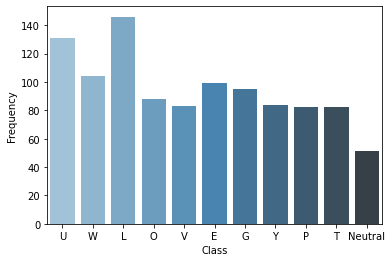

In [ ]:
import seaborn as sns
from collections import Counter

frequencies = Counter(labels)
ax = sns.barplot(x=list(frequencies.keys()), y=list(frequencies.values()), palette="Blues_d")
ax.set(xlabel='Class', ylabel='Frequency')

# Dataset Sample Visualization

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

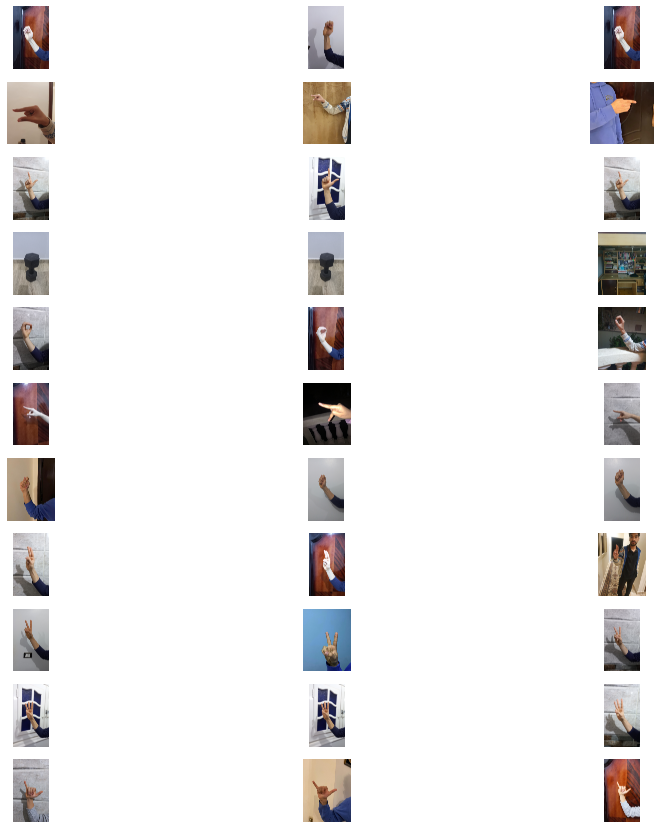

In [ ]:
from skimage import io

fig, ax = plt.subplots(11, 3)
fig.set_size_inches(15, 15)

classes = np.unique(labels)

r = 0
for cls in classes:
    class_indices = np.where(labels == cls)[0]
    rand_class_index = np.random.choice(class_indices, 3)
 
    for ind, index in enumerate(rand_class_index):
      ax[r, ind].imshow(io.imread(dataset[index]))
      ax[r, ind].axis('off')
    
    r += 1

#**Experiment 1: Direct Classification + No Transfer Learning**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

dataset_gen = ImageDataGenerator(validation_split=0.2)
trainset = dataset_gen.flow_from_directory(root_dir, target_size=(64,64), color_mode='rgb', batch_size=32, class_mode='categorical', subset='training')
testset = dataset_gen.flow_from_directory(root_dir, target_size=(64,64), color_mode='rgb', batch_size=32, class_mode='categorical', subset='validation')

Found 841 images belonging to 11 classes.
Found 204 images belonging to 11 classes.


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, kernel_initializer=keras.initializers.HeNormal(), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=11, activation="softmax"))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                      

In [ ]:
model_hist = model.fit(trainset, validation_data=testset, callbacks=[early_stopping], epochs=100)

Epoch 1/100
27/27 [==============================] - 111s 4s/step - loss: 2.8672 - accuracy: 0.3888 - val_loss: 3.5328 - val_accuracy: 0.1225
Epoch 2/100
27/27 [==============================] - 108s 4s/step - loss: 0.9494 - accuracy: 0.7491 - val_loss: 3.2496 - val_accuracy: 0.1912
Epoch 3/100
27/27 [==============================] - 112s 4s/step - loss: 0.4401 - accuracy: 0.8704 - val_loss: 2.9832 - val_accuracy: 0.1422
Epoch 4/100
27/27 [==============================] - 115s 4s/step - loss: 0.2745 - accuracy: 0.9168 - val_loss: 2.8551 - val_accuracy: 0.1422
Epoch 5/100
27/27 [==============================] - 107s 4s/step - loss: 0.1761 - accuracy: 0.9536 - val_loss: 2.8565 - val_accuracy: 0.1127
Epoch 6/100
27/27 [==============================] - 104s 4s/step - loss: 0.1062 - accuracy: 0.9738 - val_loss: 3.0304 - val_accuracy: 0.0882
Epoch 7/100
27/27 [==============================] - 104s 4s/step - loss: 0.0820 - accuracy: 0.9810 - val_loss: 3.0767 - val_accuracy: 0.1324


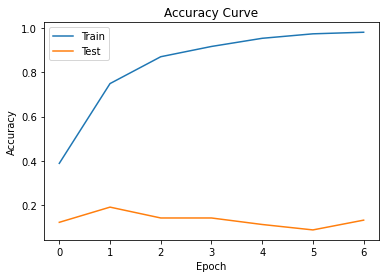

In [ ]:
from matplotlib import pyplot as plt

plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["Train", "Test"])

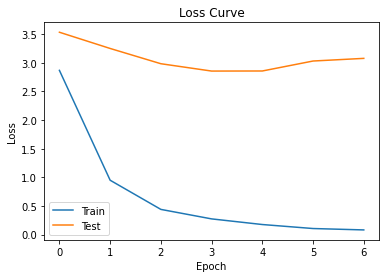

In [ ]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["Train", "Test"])

#**Experiment 2: Direct Classification using Transfer Learning**

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input 

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
for layer in vgg_base.layers:
  # if "block5" not in layer.name:
    layer.trainable = False

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

dataset_gen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
trainset = dataset_gen.flow_from_directory(root_dir, target_size=(64,64), color_mode='rgb', batch_size=32, class_mode='categorical', subset='training')
testset = dataset_gen.flow_from_directory(root_dir, target_size=(64,64), color_mode='rgb', batch_size=32, class_mode='categorical', subset='validation')

Found 841 images belonging to 11 classes.
Found 204 images belonging to 11 classes.


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model = keras.Sequential()
model.add(vgg_base) 
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(8192,activation='relu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 8192)              16785408  
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)              33558528  
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 11)               

In [ ]:
model_hist = model.fit(trainset, validation_data=testset, callbacks=[early_stopping], epochs=100)

Epoch 1/100
27/27 [==============================] - 110s 4s/step - loss: 20.9079 - accuracy: 0.2806 - val_loss: 17.0526 - val_accuracy: 0.0833
Epoch 2/100
27/27 [==============================] - 91s 3s/step - loss: 8.4461 - accuracy: 0.5993 - val_loss: 19.1483 - val_accuracy: 0.0784
Epoch 3/100
27/27 [==============================] - 93s 3s/step - loss: 5.9458 - accuracy: 0.7182 - val_loss: 18.7127 - val_accuracy: 0.0735
Epoch 4/100
27/27 [==============================] - 90s 3s/step - loss: 3.5697 - accuracy: 0.7943 - val_loss: 16.3326 - val_accuracy: 0.1618
Epoch 5/100
27/27 [==============================] - 92s 3s/step - loss: 2.8680 - accuracy: 0.8252 - val_loss: 23.7748 - val_accuracy: 0.1127
Epoch 6/100
27/27 [==============================] - 91s 3s/step - loss: 1.3524 - accuracy: 0.8811 - val_loss: 22.3493 - val_accuracy: 0.1569
Epoch 7/100
27/27 [==============================] - 91s 3s/step - loss: 1.6914 - accuracy: 0.8870 - val_loss: 25.1401 - val_accuracy: 0.1373
Epoc

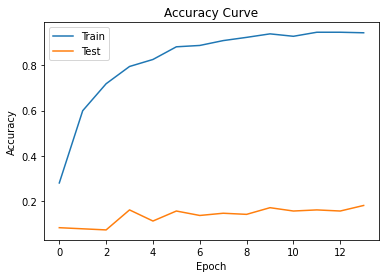

In [ ]:
from matplotlib import pyplot as plt

plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["Train", "Test"])

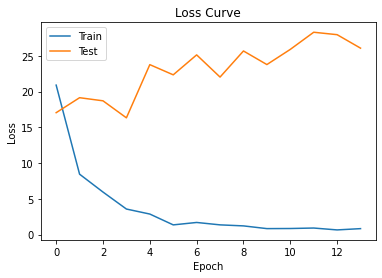

In [ ]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["Train", "Test"])

#**Experiment 3: Hand Segmentation and Classification using Transfer Learning (freeze all VGG16 layers)**

In [ ]:
image_dataset = keras.utils.image_dataset_from_directory(
    directory= root_dir,
    labels = 'inferred',
    batch_size=32,
    class_names=['E','G','L','Neutral','O','P','T','U','V','W','Y'],
    seed=42)

Found 1045 files belonging to 11 classes.


In [ ]:
images = []
labels = []

for image_batch, label_batch in tfds.as_numpy(image_dataset.unbatch()): 
  images.append(image_batch)
  labels.append(label_batch)

####**Use cvzone to detect hand**
https://aihubprojects.com/hand-detection-gesture-recognition-opencv-python/

In [ ]:
!pip install cvzone
!pip install mediapipe

  Created wheel for cvzone: filename=cvzone-1.5.6-py3-none-any.whl size=18768 sha256=0fea165bfbf5b19538881aab7b71799239bb8f1d091d7ec1693124524adce065
  Stored in directory: /root/.cache/pip/wheels/c1/e8/e9/80f482161ba9f5dcf4832b76ac70540edd11a3136a58445c52
Successfully built cvzone
     |████████████████████████████████| 32.7 MB 1.2 MB/s 


In [ ]:
import cvzone
import mediapipe
from cvzone.HandTrackingModule import HandDetector

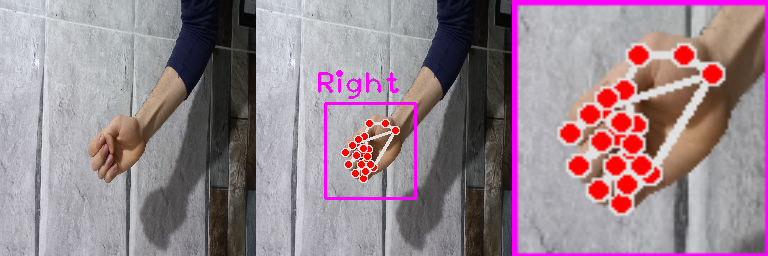

In [ ]:
detector = HandDetector(detectionCon=False, maxHands=1)

image = np.uint8(images[900])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hand = detector.findHands(image)

x, y, w, h = hand[0][0]['bbox']
segmented = hand[1][y-20:y+h+20, x-20:x+w+20]

hand_dectection = np.concatenate((cv2.cvtColor(np.uint8(images[900]), cv2.COLOR_BGR2RGB), hand[1], cv2.resize(segmented, (256, 256))), axis=1)

cv2_imshow(hand_dectection)

# Hand Sgementation

In [ ]:
segmented_images = []
segmented_labels = []
image_paths = []

In [ ]:
from skimage.transform import resize

detector = HandDetector(detectionCon=False, maxHands=1)

for image, label, path in zip(images, labels, image_dataset.file_paths):
  
  image = np.uint8(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  hand = detector.findHands(image)
  
  if label == 3:
    segmented_images.append(resize(image, (64, 64)))
    segmented_labels.append(label)
    image_paths.append(path)

  if len(hand[0]) != 0:
    x, y, w, h = hand[0][0]['bbox']
    if x < 0:
      x = 0
    if y < 0:
      y = 0
      
    segmented_images.append(resize(hand[1][y:y+h, x:x+w], (64, 64)))
    segmented_labels.append(label)
    image_paths.append(path)

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Class')]

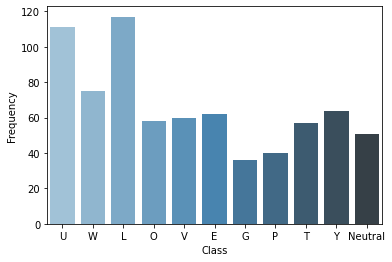

In [ ]:
import seaborn as sns

frequencies= {'U': 111,
              'W': 75,
              'L': 117,
              'O': 58,
              'V': 60,
              'E': 62,
              'G': 36,
              'P': 40,
              'T': 57,
              'Y': 64,
              'Neutral': 51
              }
ax = sns.barplot(x=list(frequencies.keys()), y=list(frequencies.values()), palette="Blues_d")
ax.set(xlabel='Class', ylabel='Frequency')

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Class')]

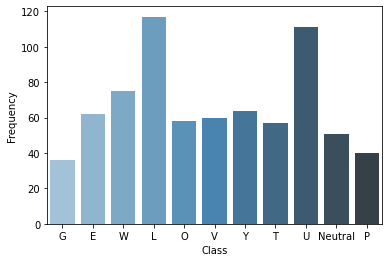

In [ ]:
frequencies = Counter(segmented_labels)
frequencies = dict((image_dataset.class_names[key], value) for (key, value) in frequencies.items())
ax = sns.barplot(x=list(frequencies.keys()), y=list(frequencies.values()), palette="Blues_d")
ax.set(xlabel='Class', ylabel='Frequency')

# ASL Classification Model Training

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, image_paths_train, image_paths_test = train_test_split(segmented_images, segmented_labels, image_paths, test_size=0.1, stratify=segmented_labels, random_state=0)

In [ ]:
from tensorflow import keras
from keras import layers, initializers, optimizers, losses

from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
X_train = np.array(X_train).reshape(len(X_train), 64, 64, 3)
X_test = np.array(X_test).reshape(len(X_test), 64, 64, 3)

In [ ]:
len(X_train), len(X_test)

(657, 74)

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255, brightness_range=[0.4, 1.5], shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.2)
train_data = data_gen.flow(X_train, y_train, batch_size=32, subset='training')
val_data = data_gen.flow(X_train, y_train, batch_size=32, subset='validation')

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
for layer in vgg_base.layers:
  # if "block5" not in layer.name:
    layer.trainable = False

In [ ]:
model = keras.Sequential()
model.add(vgg_base) 
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(8192,activation='relu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 8192)              16785408  
                                                                 
 dropout_4 (Dropout)         (None, 8192)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              33558528  
                                                                 
 dropout_5 (Dropout)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 11)               

In [ ]:
model_hist = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=100, shuffle=True)

Epoch 1/100
17/17 [==============================] - 3s 132ms/step - loss: 2.5903 - accuracy: 0.1939 - val_loss: 2.0389 - val_accuracy: 0.4122
Epoch 2/100
17/17 [==============================] - 1s 82ms/step - loss: 2.0768 - accuracy: 0.3308 - val_loss: 1.5773 - val_accuracy: 0.5344
Epoch 3/100
17/17 [==============================] - 1s 84ms/step - loss: 1.7451 - accuracy: 0.4430 - val_loss: 1.4833 - val_accuracy: 0.5344
Epoch 4/100
17/17 [==============================] - 1s 82ms/step - loss: 1.5570 - accuracy: 0.5095 - val_loss: 1.3780 - val_accuracy: 0.5649
Epoch 5/100
17/17 [==============================] - 1s 79ms/step - loss: 1.4362 - accuracy: 0.5380 - val_loss: 1.2285 - val_accuracy: 0.5954
Epoch 6/100
17/17 [==============================] - 1s 79ms/step - loss: 1.3521 - accuracy: 0.5798 - val_loss: 1.3595 - val_accuracy: 0.5878
Epoch 7/100
17/17 [==============================] - 1s 80ms/step - loss: 1.3351 - accuracy: 0.5970 - val_loss: 1.1529 - val_accuracy: 0.6260
Epoch

## Accuracy Curve

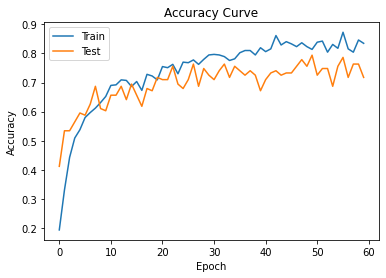

In [ ]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["Train", "Test"])

## Loss Curve

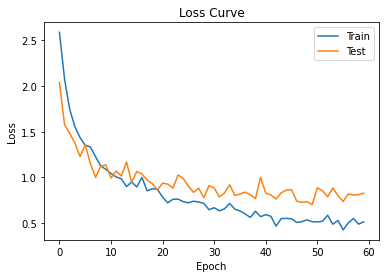

In [ ]:
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["Train", "Test"])

# **Experiment 4 : Hand Sgementation and Classification using Transfer Learning (unfreeze all VGG16 layers)**

In [ ]:
from tensorflow import keras
from keras import layers, initializers, optimizers, losses

from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
vgg_base.trainable = True

In [ ]:
model = keras.Sequential()
model.add(vgg_base) 
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(8192,activation='relu'))
model.add(keras.layers.Dropout(0.8))
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(11, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 8192)              16785408  
                                                                 
 dropout_6 (Dropout)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 4096)              33558528  
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 dense_11 (Dense)            (None, 11)               

In [ ]:
model_hist_2 = model.fit(train_data, validation_data=val_data, callbacks=[early_stopping], epochs=100, shuffle=True)

Epoch 1/100
17/17 [==============================] - 6s 193ms/step - loss: 2.5707 - accuracy: 0.1255 - val_loss: 2.3070 - val_accuracy: 0.1985
Epoch 2/100
17/17 [==============================] - 2s 132ms/step - loss: 2.1960 - accuracy: 0.2548 - val_loss: 1.8024 - val_accuracy: 0.3740
Epoch 3/100
17/17 [==============================] - 2s 94ms/step - loss: 1.8194 - accuracy: 0.3878 - val_loss: 1.6623 - val_accuracy: 0.4198
Epoch 4/100
17/17 [==============================] - 2s 90ms/step - loss: 1.5203 - accuracy: 0.4734 - val_loss: 1.3499 - val_accuracy: 0.5115
Epoch 5/100
17/17 [==============================] - 2s 135ms/step - loss: 1.3150 - accuracy: 0.5361 - val_loss: 1.4822 - val_accuracy: 0.5267
Epoch 6/100
17/17 [==============================] - 3s 159ms/step - loss: 1.1951 - accuracy: 0.5722 - val_loss: 1.1461 - val_accuracy: 0.5878
Epoch 7/100
17/17 [==============================] - 3s 146ms/step - loss: 1.0170 - accuracy: 0.6635 - val_loss: 1.0956 - val_accuracy: 0.6183
E

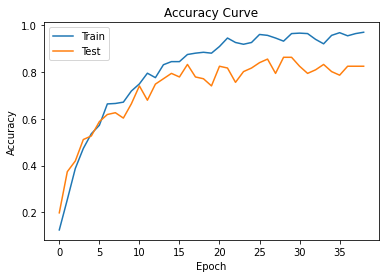

In [ ]:
plt.plot(model_hist_2.history['accuracy'])
plt.plot(model_hist_2.history['val_accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend(["Train", "Test"])

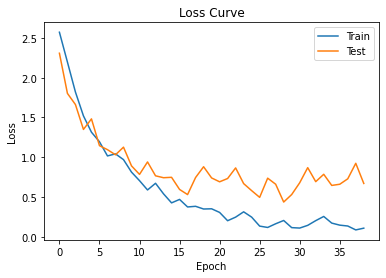

In [ ]:
plt.plot(model_hist_2.history['loss'])
plt.plot(model_hist_2.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["Train", "Test"])

In [ ]:
import pickle

weights_file = open("/content/drive/MyDrive/Files/asl_model.sav", 'wb')
pickle.dump(model, weights_file)
weights_file.close()

INFO:tensorflow:Assets written to: ram://551df202-4532-4826-9352-f22e3d9633a0/assets


# Model Evaluation and Results

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)
train_set = data_gen.flow(X_train, y_train, batch_size=32, shuffle  = False)
test_set = data_gen.flow(X_test, y_test, batch_size=32, shuffle  = False)

In [ ]:
class_map = dict((ind, cls) for ind, cls in enumerate(image_dataset.class_names))
train_y_true = np.vectorize(class_map.get)(y_train)
test_y_true = np.vectorize(class_map.get)(y_test)

              precision    recall  f1-score   support

           E       0.95      0.98      0.96        56
           G       0.91      0.91      0.91        32
           L       1.00      0.97      0.99       105
     Neutral       1.00      0.96      0.98        46
           O       1.00      0.92      0.96        52
           P       0.94      0.83      0.88        36
           T       0.98      0.98      0.98        51
           U       0.94      0.98      0.96       100
           V       0.83      0.98      0.90        54
           W       0.95      0.90      0.92        67
           Y       0.97      0.98      0.97        58

    accuracy                           0.95       657
   macro avg       0.95      0.94      0.95       657
weighted avg       0.96      0.95      0.95       657



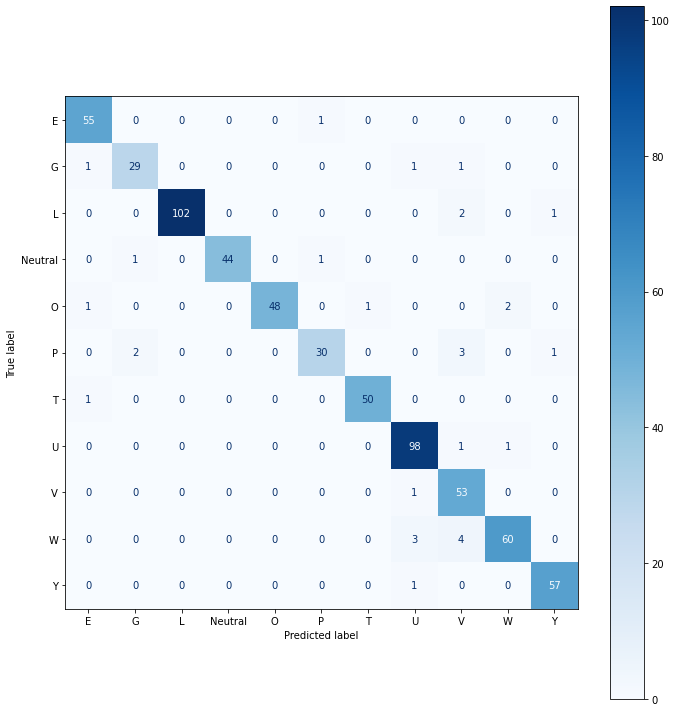

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

train_y_pred = model.predict(train_set)
train_y_pred = np.argmax(train_y_pred, axis=1)
train_y_pred = np.vectorize(class_map.get)(train_y_pred)

print(classification_report(train_y_true, train_y_pred))
cm = confusion_matrix(train_y_true, train_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.values())
fig, ax = plt.subplots(1,1,figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

           E       0.50      0.50      0.50         6
           G       1.00      0.75      0.86         4
           L       1.00      1.00      1.00        12
     Neutral       1.00      1.00      1.00         5
           O       1.00      0.83      0.91         6
           P       1.00      0.50      0.67         4
           T       0.75      0.50      0.60         6
           U       0.91      0.91      0.91        11
           V       0.56      0.83      0.67         6
           W       1.00      1.00      1.00         8
           Y       0.56      0.83      0.67         6

    accuracy                           0.82        74
   macro avg       0.84      0.79      0.80        74
weighted avg       0.85      0.82      0.83        74



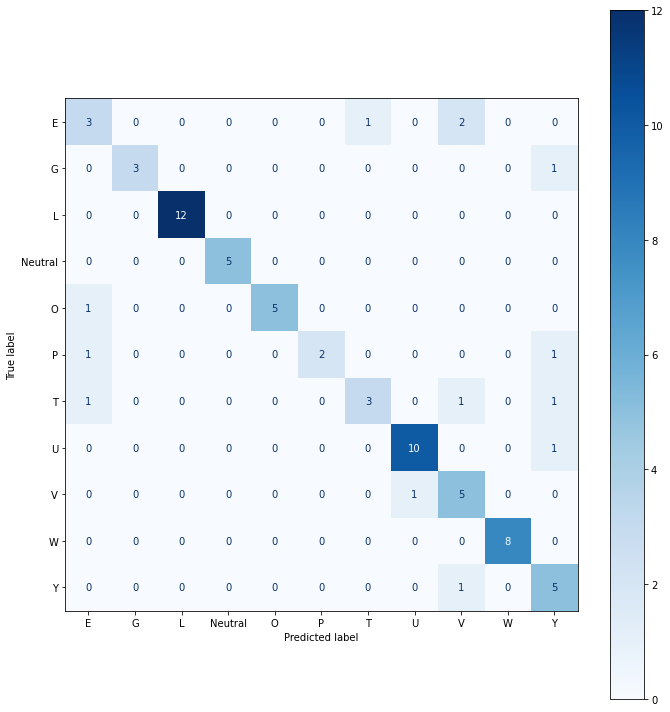

In [ ]:
test_y_pred = model.predict(test_set)
test_y_pred = np.argmax(test_y_pred, axis=1)
test_y_pred = np.vectorize(class_map.get)(test_y_pred)

print(classification_report(test_y_true, test_y_pred))
cm = confusion_matrix(test_y_true, test_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_map.values())
fig, ax = plt.subplots(1,1,figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.tight_layout()
plt.show()

# TSNE Embedding

In [ ]:
from keras import backend as be

output_layer = model.get_layer(model.layers[-3].name)
output_features = be.function([model.input], [output_layer.output, model.output])

images_ = []
features_ = []
predictions_ = []
for i in range(len(test_set)):
  batch = test_set.next()
  images_.append(batch[0])
  features, predictions = output_features(batch[0])
  features_.append(features)
  predictions_.append(predictions)

In [ ]:
images_paths = image_paths_test
images_ = np.ma.row_stack(images_).data
features_ = np.ma.row_stack(features_).data
predictions_ = np.ma.row_stack(predictions_).data

In [ ]:
predictions = predictions_.argmax(axis=1)
classes = np.array(image_dataset.class_names)[predictions]

In [ ]:
from sklearn.manifold import TSNE

features_reduced = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(features_)
fx = (features_reduced[:, 0] - features_reduced[:, 0].min()) / (features_reduced[:, 0].max() - features_reduced[:, 0].min())
fy = (features_reduced[:, 1] - features_reduced[:, 1].min()) / (features_reduced[:, 1].max() - features_reduced[:, 1].min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


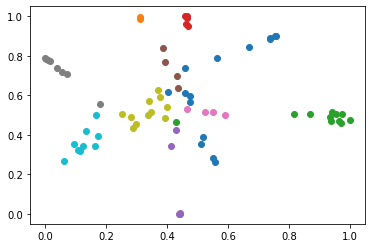

In [ ]:
import matplotlib.pyplot as plt

for ind, cls in enumerate(image_dataset.class_names):
  current_class_cluster = np.where(classes == cls)[0]
  plt.scatter(fx[current_class_cluster], fy[current_class_cluster])

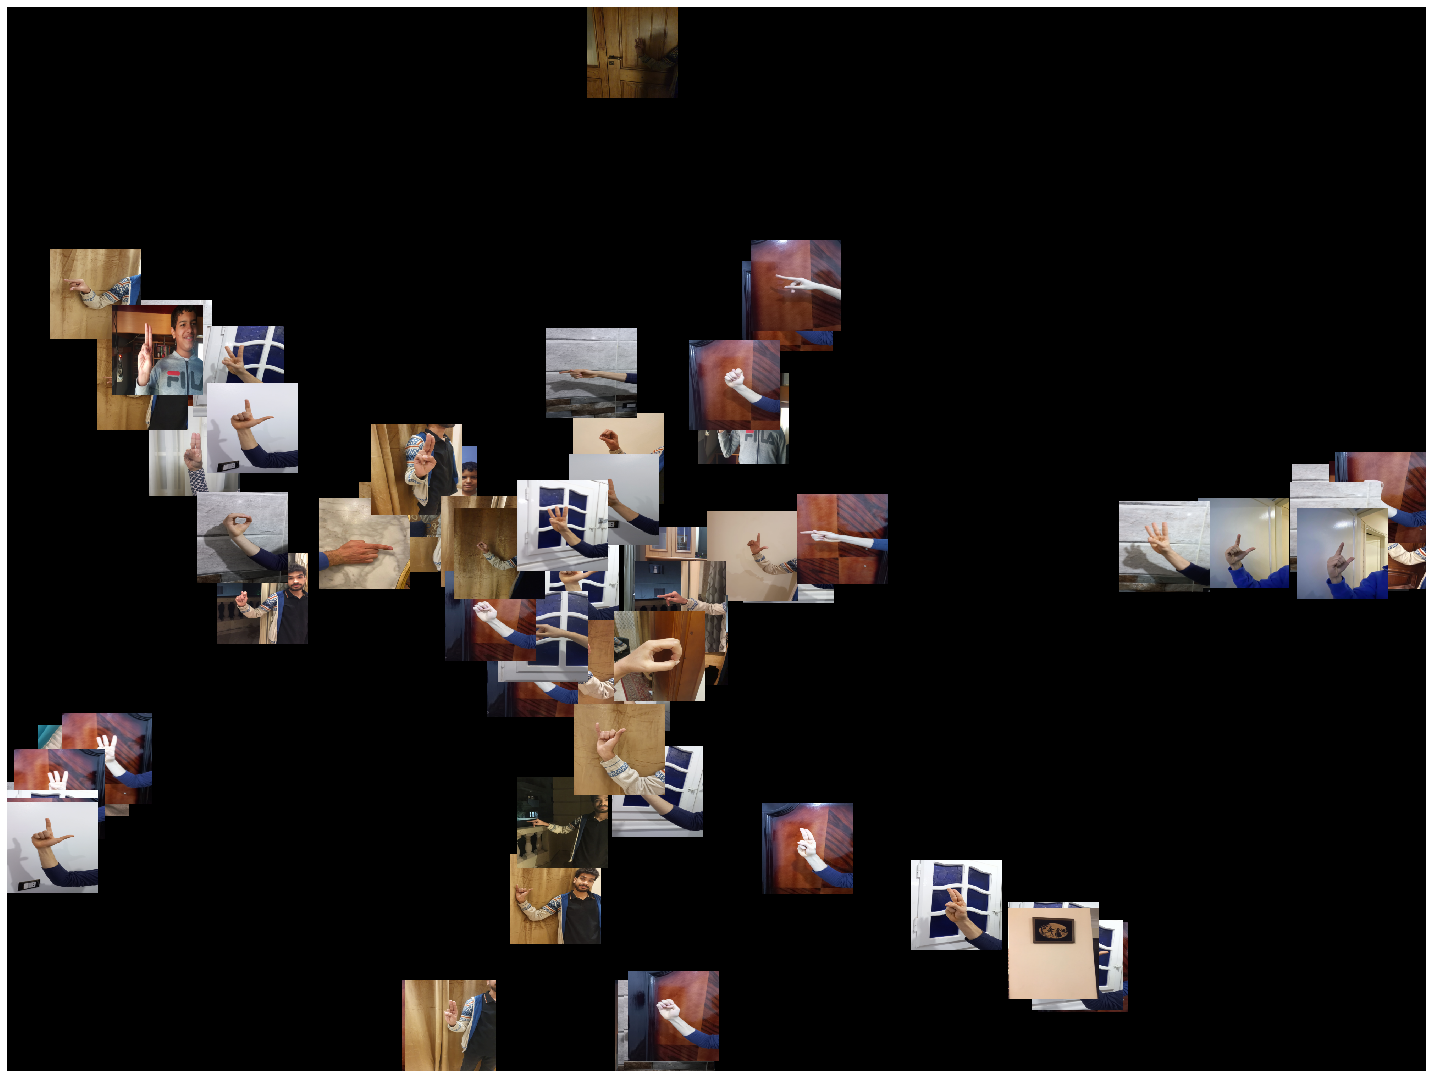

In [ ]:
from skimage import io

width = 4000
height = 3000

canvas = np.zeros((height, width, 3))
for ind, path in enumerate(images_paths):
  img = resize(io.imread(path), (256, 256))
  img_height, img_width = img.shape[0], img.shape[1]

  min_x, max_x = 0, width-1
  min_y, max_y = 0, height-1

  left_x = int(fx[ind] * width) - (img_width // 2)
  right_x = int(fx[ind] * width) + (img_width // 2)

  top_y = int(fy[ind] * height) - (img_height // 2)
  bottom_y = int(fy[ind] * height) + (img_height // 2)
  
  if(left_x < min_x):
    left_x = min_x
    right_x = min_x + img_width
  elif(right_x > max_x):
    left_x = max_x - img_width
    right_x = max_x
  
  if(top_y < min_y):
    top_y = min_y
    bottom_y = min_y + img_height
  elif(bottom_y > max_y):
    top_y = max_y - img_height
    bottom_y = max_y

  canvas[top_y:bottom_y, left_x:right_x] = img

plt.figure(figsize=(20, 20))
plt.axis('off')
io.imshow(canvas)

In [ ]:
!pip install cvlib

     |████████████████████████████████| 13.1 MB 1.5 MB/s 
  Created wheel for cvlib: filename=cvlib-0.2.7-py3-none-any.whl size=10046385 sha256=0df6e52ee87744915223b05e60c9da8f846569ef5be3bfe35f94440170f1d1ae
  Stored in directory: /root/.cache/pip/wheels/8e/d7/31/bc643bd3a8b11a7368b1ab1d8a6299b33b462ed0b0683ddc5a
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=2a23b8e459fd1e0fdfaca340e438e2bf4a3551738f33261be343e6c8d7c90707
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built cvlib progressbar


In [ ]:
import pickle 

asl_model_file = open("/content/drive/MyDrive/Files/asl_model", "rb")
asl_model = pickle.load(asl_model_file)

# ASL Recognition on Unseen Test Images

In [ ]:
from skimage import io
import tensorflow as tf
from skimage.transform import resize 
from cvlib.object_detection import draw_bbox
from keras.applications.vgg16 import preprocess_input
 
def asl_recognition(model, image, classes):
  detector = HandDetector(detectionCon=False, maxHands=1)

  img = np.uint8(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  hand = detector.findHands(img)

  if len(hand[0]) != 0:
    bbox = hand[0][0]['bbox']
    x, y, w, h = bbox 
    segmented_hand = preprocess_input(hand[1][y:y+h, x:x+w])
  else:
    x, y, w, h = int(image.shape[1]/2), int(image.shape[0]/2), 200, 200 
    segmented_hand = preprocess_input(image)
  
  segmented_hand /= 255
  segmented_hand = tf.expand_dims(resize(segmented_hand, (64,64)), axis=0)
  
  pred = model.predict(segmented_hand)
  cls = np.argmax(pred, axis=1)
  conf = pred[0][cls]
  label = classes[cls[0]]
  
  image = cv2.rectangle(image, (x-10, y-10), (x + w + 10, y + h + 10), (0,132,176), 1)
  image = np.uint8(image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  output_image = cv2.putText(image, "Class: " + label + " Confidence Score: " + str(conf[0]), (x-80, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (176,132,0), 2)

  return output_image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


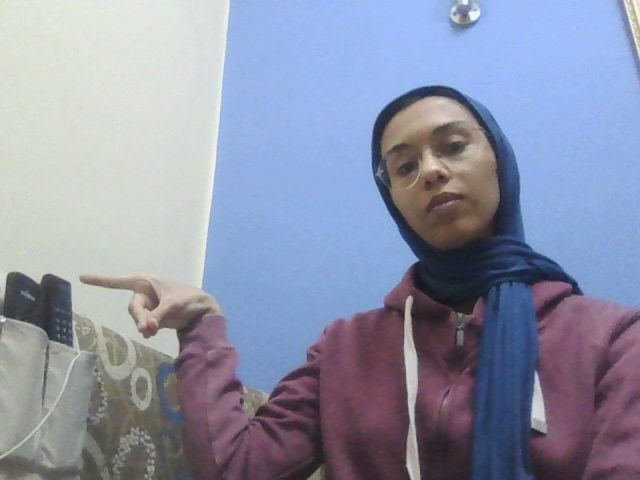

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

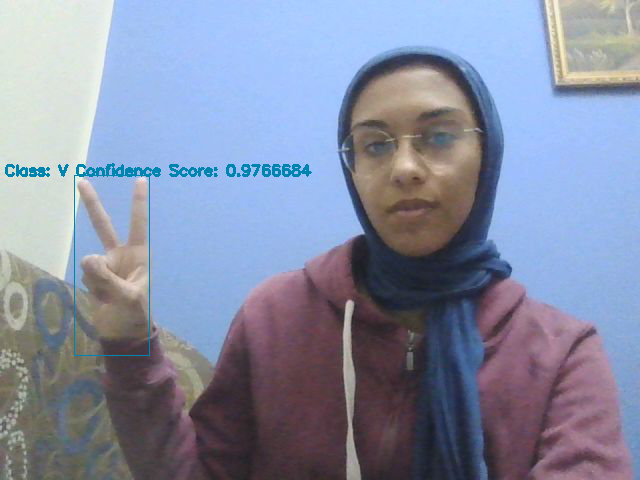

True

In [ ]:
classified_letter = asl_recognition(asl_model, io.imread("/content/photo.jpg"), image_dataset.class_names)
cv2_imshow(classified_letter)
cv2.imwrite("v-labeled.jpg", classified_letter)

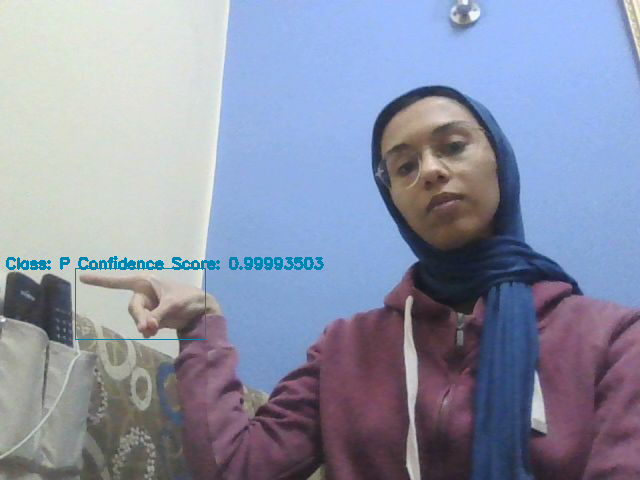

True

In [ ]:
classified_letter = asl_recognition(asl_model, io.imread("/content/photo.jpg"), image_dataset.class_names)
cv2_imshow(classified_letter)
cv2.imwrite("p-labeled.jpg", classified_letter)